# Riesgo de crédito con modelos explicables y evaluación de equidad

Una institución financiera desea apoyar su decisión de originación de crédito identificando, con anticipación, solicitantes con alto riesgo de incumplimiento. Tu misión es construir una comparativa técnica de modelos que produzcan probabilidades calibradas y explicables, evaluar su desempeño y analizar posibles brechas de equidad entre subgrupos. El resultado debe traducirse en recomendaciones operativas y en la justificación de qué modelo conviene utilizar y por qué.

### Team members:

* Mario David Hernandez Pantoja
* Oscar Martinez Estevez
* Gerardo Hernandez Widman
* Moises Jesus Carrillo Alonzo
* Braulio Jesus Perez Tamayo

# Datos
Usa el German Credit del UCI Machine Learning Repository. Puedes elegir entre:
* Statlog (German Credit Data): 1,000 instancias y 20 variables; clasifica solicitantes como “good/bad” e incluye una matriz de costos: https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data
* South German Credit: versión documentada y corregida (700 “good” / 300 “bad”, 20 predictores), con notas de muestreo y codificación; suele facilitar la interpretación y prácticas de explicabilidad: https://archive.ics.uci.edu/dataset/522/south+german+credit


# Requerimientos del Análisis
1) **Análisis Exploratorio y Calidad de Datos**

Caracterización completa del conjunto de datos incluyendo distribución de la clase, tipificación de variables, detección y tratamiento de faltantes, duplicados y outliers. Se espera una narrativa visual (gráficos y tablas) que conecte hallazgos con hipótesis de negocio sobre segmentos de mayor riesgo. Debes dejar por escrito las reglas de limpieza aplicadas y justificar su impacto.

2) **Modelado con probabilidades calibradas**

Se requiere entrenar y comparar cuatro enfoques bajo un mismo split estratificado o validación equivalente (fijar semilla para reproducibilidad) y calibrar probabilidades (Platt o Isotónica) usando únicamente datos de entrenamiento/validación:
1. Modelo de regresión logística junto con su reporte de coeficientes y odds ratios.
2. Modelo basado en árboles de decisión y extracción explícita de reglas interpretables.
3. Modelo ensemble (por ejemplo, Random Forest o Gradient Boosting).
4. Red neuronal.

Debes optimizar el umbral de decisión (además del 0.5) con un criterio declarado y reportar el efecto del umbral elegido.

3) **Métricas y comparación fuera de muestra**

Realiza la evaluación de los modelos de acuerdo a las métricas seleccionadas (Accuracy, Precision, Recall, F1, ROC-AUC y PR-AUC) junto con la matriz de confusión correspondiente. La comparación debe discutir estabilidad (varianza esperada), robustez ante desbalance y sensibilidad al umbral. Incluye curvas ROC y PR para visualizar el trade-off. 

4) **Explicabilidad global y local**

El análisis debe facilitar la trazabilidad de por qué un solicitante es clasificado como riesgoso:

* Global: interpreta coeficientes y odds (logística), muestra importancias (árbol/ensemble) y presenta 2–3 reglas del árbol que definan segmentos de alto riesgo.
* Local: explica al menos tres casos individuales (uno mal clasificado, uno “frontera” y uno de riesgo alto). Puedes usar SHAP o LIME; para la red neuronal, considera Integrated Gradients o SHAP Kernel según factibilidad. La explicación debe ser comprensible para negocio (texto corto + visual).

5) **Evaluación de equidad (fairness)**

Selecciona uno o dos atributos comparativos presentes en el dataset (grupos de edad o estado civil) y contrasta resultados entre subgrupos. Reporta al menos dos métricas de equidad (por ejemplo, Demographic Parity: tasa de positivos, y Equal Opportunity: TPR/Recall por grupo) e incluye tamaños muestrales y una discusión honesta de limitaciones (histórico, proxies, label bias).

6) **Recomendación operativa**

Con base en desempeño, explicabilidad y equidad, cierra con una propuesta de uso, un umbral recomendado y plan de monitoreo y mantenimiento (monitoreo periódico, recalibración, auditorías de equidad y documentación de decisiones).

# Entregables
1. Notebook con secciones claramente identificadas que correspondan a los requerimientos anteriores:
    * Exploración y Calidad de Datos
    * Modelado 
    * Evaluación
    * Explicabilidad
    * Evaluación de Equidad

2. Resumen ejecutivo donde concluyas qué modelo utilizar y por qué, integrando:
    * Exploración y Calidad de Datos
    * Modelado 
    * Evaluación
    * Explicabilidad
    * Evaluación de Equida

# Requerimientos del Análisis (Code)


## 1) Análisis Exploratorio y Calidad de Datos

### 0. Notas iniciales

Archivo usado: german.data (formato categórico original) y opcionalmente german.data-numeric (forma numérica ya procesada). Ambos están en la carpeta statlog+german+credit+data/.

Número de instancias: 1000.

Variables originales: 20 atributos + etiqueta (good/bad).

Semilla para reproducibilidad: RANDOM_STATE = 42.

### 1. Cargar datos

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
RANDOM_STATE = 42

In [26]:
# Nombres de columnas según german.doc (20 atributos + target)
cols = [
'checking_status', # A11..A14
'duration', # meses
'credit_history', # A30..A34
'purpose', # A40..A410
'credit_amount',
'savings', # A61..A65
'employment_since', # A71..A75
'installment_rate', # porcentaje
'personal_status_sex', # A91..A95
'other_debtors', # A101..A103
'present_residence', # años
'property', # A121..A124
'age',
'other_installment_plans', # A141..A143
'housing', # A151..A153
'existing_credits', # número
'job', # A171..A174
'people_liable', # número
'telephone', # A191..A192
'foreign_worker', # A201..A202
'target' # 1 = good, 2 = bad
]


# Leer archivo categórico
df = pd.read_csv('statlog+german+credit+data/german.data',
delim_whitespace=True, header=None, names=cols)


# Ver primeras filas
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings,employment_since,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,people_liable,telephone,foreign_worker,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


### 2. Tipificación inicial de variables

In [27]:
# Revisar tipos actuales
df.dtypes

# Convertir tipos numéricos donde apliquen (duration, credit_amount, installment_rate, present_residence, age, existing_credits, people_liable)
num_cols = ['duration','credit_amount','installment_rate','present_residence','age','existing_credits','people_liable']
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Target: convertir a 0/1 (0 = good, 1 = bad) para modelos posteriores
# En este dataset: 1 = Good, 2 = Bad
df['target'] = df['target'].map({1:0, 2:1}).astype(int)

# Resumen rápido
print(df[num_cols].describe().T)
print('\nCategorical sample counts:')
for c in df.select_dtypes(include='object').columns:
    print(c, '->', df[c].nunique())

                    count      mean          std    min     25%     50%  \
duration           1000.0    20.903    12.058814    4.0    12.0    18.0   
credit_amount      1000.0  3271.258  2822.736876  250.0  1365.5  2319.5   
installment_rate   1000.0     2.973     1.118715    1.0     2.0     3.0   
present_residence  1000.0     2.845     1.103718    1.0     2.0     3.0   
age                1000.0    35.546    11.375469   19.0    27.0    33.0   
existing_credits   1000.0     1.407     0.577654    1.0     1.0     1.0   
people_liable      1000.0     1.155     0.362086    1.0     1.0     1.0   

                       75%      max  
duration             24.00     72.0  
credit_amount      3972.25  18424.0  
installment_rate      4.00      4.0  
present_residence     4.00      4.0  
age                  42.00     75.0  
existing_credits      2.00      4.0  
people_liable         1.00      2.0  

Categorical sample counts:
checking_status -> 4
credit_history -> 5
purpose -> 10
savings -> 5

### 3. Distribución de la clase (target)

Conteos:
 target
0    700
1    300
Name: count, dtype: int64

Proporciones:
 target
0    0.7
1    0.3
Name: proportion, dtype: float64


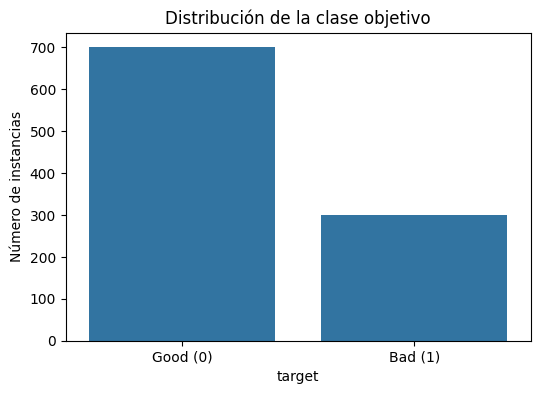

In [28]:
# Conteo y proporción
counts = df['target'].value_counts().sort_index()
props = df['target'].value_counts(normalize=True).sort_index()
print('Conteos:\n', counts)
print('\nProporciones:\n', props)

# Gráfico
plt.figure(figsize=(6,4))
sns.barplot(x=counts.index, y=counts.values)
plt.xticks([0,1], ['Good (0)', 'Bad (1)'])
plt.title('Distribución de la clase objetivo')
plt.ylabel('Número de instancias')
plt.show()

**Interpretación (negocio)**

* Conocer si existe desbalance. En el dataset clásico suele haber más buenos que malos. Un desbalance moderado afecta métricas como accuracy y obliga a priorizar métricas por clase (recall para malos si queremos reducir riesgo de aprobar a malos).

### 4. Valores faltantes y duplicados

In [ ]:
# Valores faltantes
missing = df.isnull().sum()
missing[missing>0]

# Duplicados
dups = df.duplicated().sum()
print('Duplicados totales:', dups)

Duplicados totales: 0


**Reglas / acciones**

* Si missing.sum()==0: no se aplica imputación.

* Si hay valores NaN en num_cols: imputar con medianas (robusto) y crear columna indicador _missing para cada num_col con NaN (para traza y modelos lineales/árboles).

* Si hay duplicados: eliminar df = df.drop_duplicates() y documentar cuántas filas se eliminaron.

Justificación: imputar con la mediana evita sesgo por outliers; marcar faltantes preserva señal útil.

### 5. Análisis univariado y bivariado (gráficos sugeridos y código)

#### 5.1 Numéricos — histogramas y boxplots

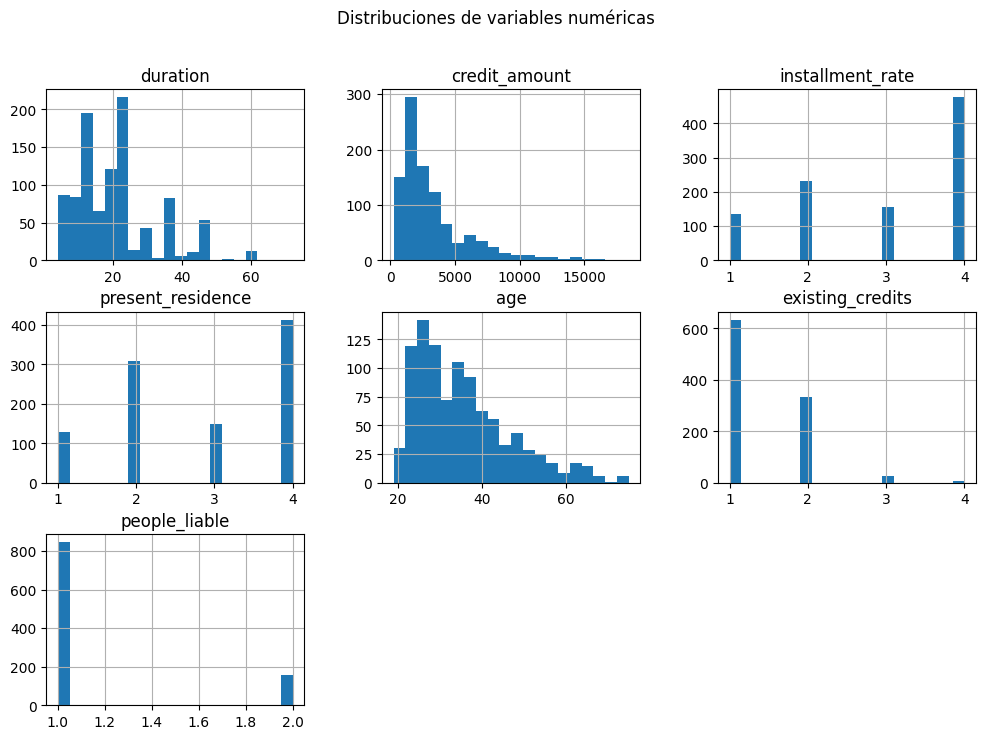

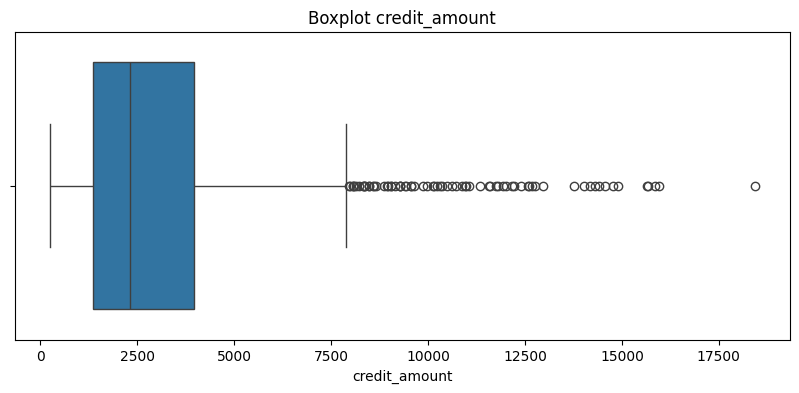

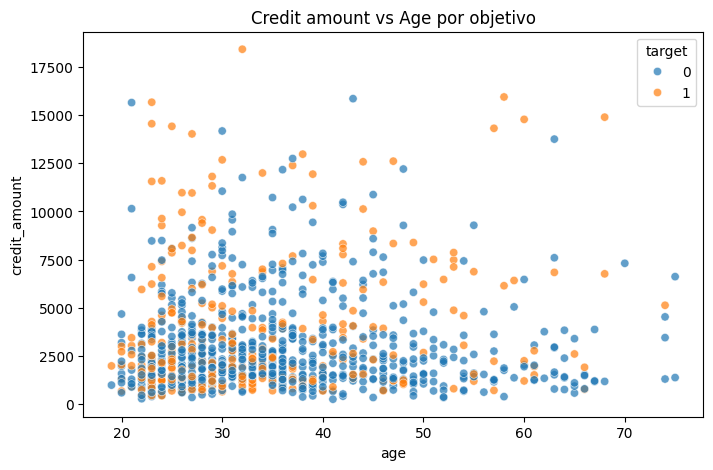

In [30]:
# Histogramas
df[num_cols].hist(bins=20, figsize=(12,8))
plt.suptitle('Distribuciones de variables numéricas')
plt.show()

# Boxplots para ver outliers (ej: credit_amount, age, duration)
plt.figure(figsize=(10,4))
sns.boxplot(x=df['credit_amount'])
plt.title('Boxplot credit_amount')
plt.show()

# Scatter: credit_amount vs age coloreado por target
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='age', y='credit_amount', hue='target', alpha=0.7)
plt.title('Credit amount vs Age por objetivo')
plt.show()

#### 5.2 Categóricas — conteos y tasas por clase

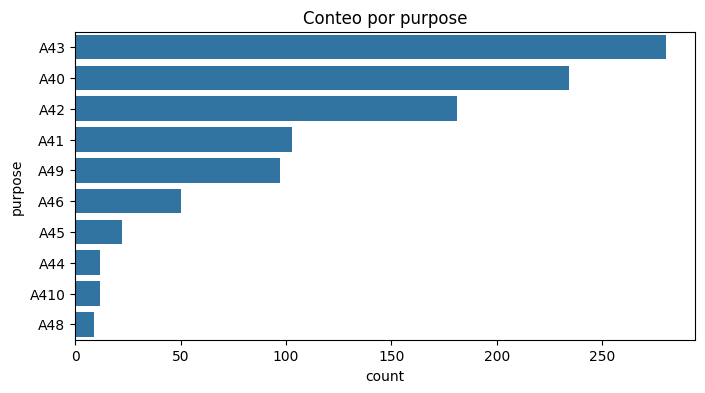

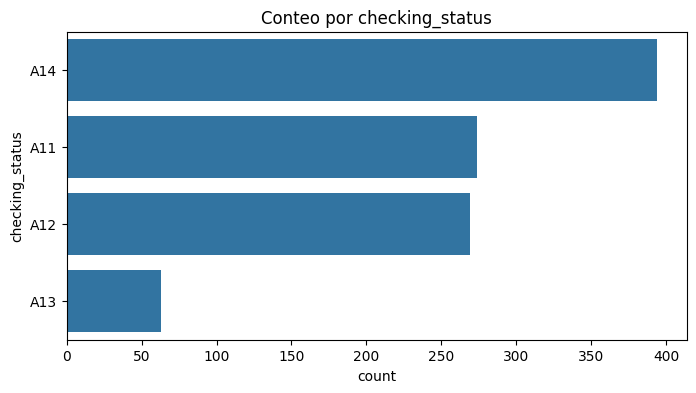

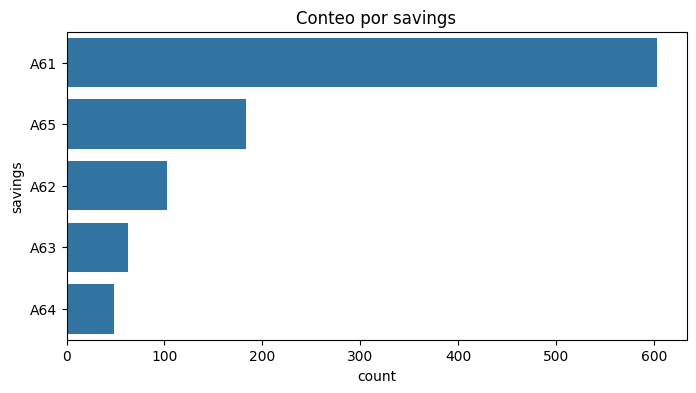

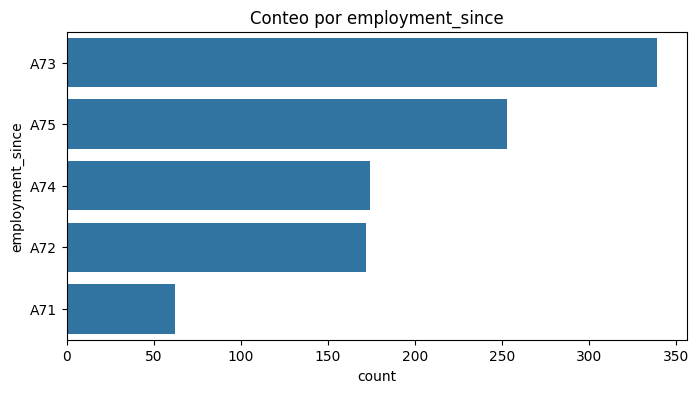

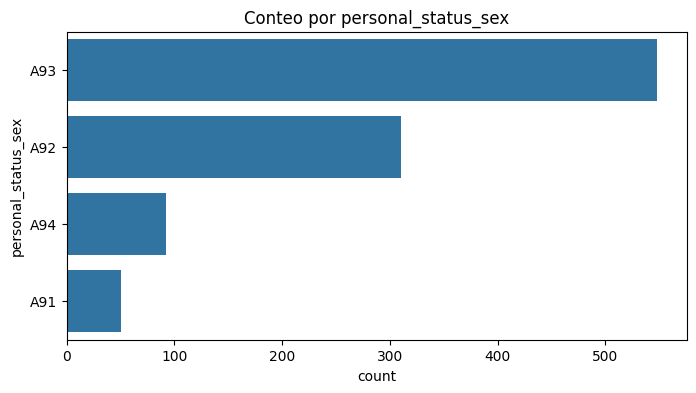

Tasa de default por purpose:
 purpose
A46     0.440000
A410    0.416667
A40     0.380342
A45     0.363636
A49     0.350515
A44     0.333333
A42     0.320442
A43     0.221429
A41     0.165049
A48     0.111111
Name: target, dtype: float64


In [31]:
cat_cols = [c for c in df.columns if df[c].dtype == 'object']

# Conteos de categorías para Atributos clave (purpose, checking_status, savings, employment_since, personal_status_sex)
for c in ['purpose','checking_status','savings','employment_since','personal_status_sex']:
    plt.figure(figsize=(8,4))
    sns.countplot(y=c, data=df, order=df[c].value_counts().index)
    plt.title(f'Conteo por {c}')
    plt.show()

# Tasa de default por categoría (ej: purpose)
default_rate = df.groupby('purpose')['target'].mean().sort_values(ascending=False)
print('Tasa de default por purpose:\n', default_rate)

**Cómo enlazar a hipótesis de negocio**

* Buscar categorías con tasa de default significativamente mayor. Por ejemplo, si "business" o "others" tienen mayor tasa de default, formular hipótesis: solicitudes para negocio pueden tener mayor riesgo (o coding issues).

* Variables numéricas: valores extremos de credit_amount pueden concentrar defaults.

### 6. Detección de outliers (reglas y código)

#### 6.1 Método IQR para variables clave

In [32]:
# Función para marcar outliers por IQR
def mark_outliers_iqr(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k * iqr
    high = q3 + k * iqr
    return ((series < low) | (series > high))

outlier_flags = pd.DataFrame()
for c in ['credit_amount','duration','age']:
    outlier_flags[c + '_out'] = mark_outliers_iqr(df[c])

outlier_flags.sum()

credit_amount_out    72
duration_out         70
age_out              23
dtype: int64

#### 6.2 Reglas prácticas de tratamiento

* credit_amount: capear (winsorize) al percentil 99 o imputar por la mediana del bin similar (por ejemplo mismo purpose y age bucket). Razon: evitar que unos pocos préstamos extremadamente grandes dominen modelos lineales.

* duration: si valores extremos son realmente errores (ej: duración = 999) corregir o eliminar; si son válidos, convertir a buckets (corto/medio/largo) para modelos lineales.

* age: capear por abajo (edad mínima razonable) y marcar jóvenes (< 18) si existen.

Código ejemplo para winsorize:

In [33]:
from scipy.stats import mstats
# winsorize al 1% y 99%
df['credit_amount_w'] = mstats.winsorize(df['credit_amount'], limits=[0.01, 0.01])

Justificación de negocio: capping reduce overfitting por outliers y mejora interpretabilidad de coeficientes.

### 7. Transformaciones y encoding (preparación para modelado)

**Estrategia recomendada**

* Variables categóricas con pocas modalidades: One-Hot Encoding (ej: housing, telephone, foreign_worker)

* Variables categóricas ordinales (employment_since, savings buckets): mapear a enteros ordenados si el orden tiene sentido.

* Para modelos lineales: usar dummies y evitar multicolinealidad (drop_first=True)

* Para árboles/ensemble: Label Encoding o mantener códigos originales.

* Escalado: solo para regresión logística y redes (StandardScaler o RobustScaler para variables numéricas). No escalar para árboles.

In [34]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
# Ejemplo simple: one-hot para purpose
df_enc = pd.get_dummies(df, columns=['purpose','checking_status','savings','personal_status_sex','housing'], drop_first=True)

# Escalado para variables numéricas si usas modelos lineales o red
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df_enc[num_cols] = scaler.fit_transform(df_enc[num_cols])

### 8. Reglas de limpieza aplicadas (documentadas)

1. Conversión de tipos: asegurar que columnas numéricas sean int/float.
    * Impacto: evita errores en modelos; permite estadísticas descriptivas correctas.
2. Mapeo de target a binario (0=Good, 1=Bad).
    * Impacto: simplifica evaluación y coincide con las métricas de riesgo (bad = evento positivo que queremos detectar).
3. Detección y eliminación de duplicados.
    * Regla: df = df.drop_duplicates().
    * Impacto: evita sobrecontar observaciones; si muchos duplicados, investigar origen.
4. Tratamiento de faltantes.
    * Regla: imputar numéricos con mediana y crear flag _is_missing por variable.
    * Impacto: mantiene robustez y preserva información que podría ser predictiva.
5. Outliers.
    * Regla: marcar outliers por IQR; winsorize al 1%/99% para credit_amount y capear extremos razonables.
    * Impacto: reduce influencia desproporcionada en coeficientes y en gradientes de redes; conserva la mayoría de datos.
6. Encoding y escalado según modelo (One-Hot para regresión, Label para árboles; escala para redes y regresión logística).
    * Impacto: prepara datos para que cada algoritmo funcione de forma óptima y que las interpretaciones (coeficientes) sean coherentes.

### 9. Hipótesis de negocio conectadas a EDA

* Hipótesis 1: solicitantes con credit_amount elevado y duration largo tienen mayor probabilidad de default. Acción: crear segmentos por quintiles y comparar tasas de default.

* Hipótesis 2: falta de savings o historial de crédito crítico (credit_history tipo A34) se asocia con mayor tasa de malos.

* Hipótesis 3: ciertas finalidades (purpose) muestran más riesgo (por ejemplo, "business" o "others").

Para comprobarlas: agrupar por esos bins/categorías y comparar target.mean(); añadir gráficas de barras con tasas de default.

## 2) Modelado con probabilidades calibradas

## 3) Métricas y comparación fuera de muestra

## 4) Explicabilidad global y local

## 5) Evaluación de equidad (fairness)

## 6) Recomendación operativa